# Import Library

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
from numpy import arange
from sklearn.metrics import r2_score
import sklearn.linear_model as linear_model
import tensorflow as tf
from tensorflow import keras

# Read data and Cleaning

In [185]:
data = pd.read_csv('./dataset/train.csv')
data = data[['Id','GrLivArea','TotRmsAbvGrd','LotArea','GarageArea','SalePrice','OverallQual','YearBuilt','YearRemodAdd','TotalBsmtSF','2ndFlrSF','Neighborhood','RoofMatl','KitchenAbvGr','LotFrontage','1stFlrSF','MasVnrArea','WoodDeckSF','OpenPorchSF','PoolArea']]

data = data[data['GarageArea'] != 0]
data = data[data['LotArea'] <= 30000]
data = data[data['GrLivArea'] <= 3000]
data.drop(data[data['GarageArea'] == 0].index, inplace=True)
data.drop(data[data['MasVnrArea'] == 0].index, inplace=True)
data.drop(data[data['WoodDeckSF'] == 0].index, inplace=True)
data.drop(data[data['GrLivArea'] > 3000].index, inplace=True)
data.dropna(inplace=True)


data.to_csv('dataset/cleanData.csv', index=False)
data.describe

<bound method NDFrame.describe of         Id  GrLivArea  TotRmsAbvGrd  LotArea  GarageArea  SalePrice  \
4        5       2198             9    14260         836     250000   
6        7       1694             7    10084         636     307000   
11      12       2324            11    11924         736     345000   
13      14       1494             7    10652         840     279500   
20      21       2376             9    14215         853     325300   
...    ...        ...           ...      ...         ...        ...   
1422  1423        848             3     4435         420     136500   
1426  1427       2127             5    10944         525     271000   
1442  1443       2007            10    11003         812     310000   
1444  1445       1422             7     8500         626     179600   
1456  1457       2073             7    13175         500     210000   

      OverallQual  YearBuilt  YearRemodAdd  TotalBsmtSF  2ndFlrSF  \
4               8       2000          2000  

# Change data to int and float

In [186]:
data_num = data.select_dtypes(include = ['float64' , 'int64'])
data_num.head()

,Id,GrLivArea,TotRmsAbvGrd,LotArea,GarageArea,SalePrice,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,2ndFlrSF,KitchenAbvGr,LotFrontage,1stFlrSF,MasVnrArea,WoodDeckSF,OpenPorchSF,PoolArea
4,5,2198,9,14260,836,250000,8,2000,2000,1145,1053,1,84.0,1145,350.0,192,84,0
6,7,1694,7,10084,636,307000,8,2004,2005,1686,0,1,75.0,1694,186.0,255,57,0
11,12,2324,11,11924,736,345000,9,2005,2006,1175,1142,1,85.0,1182,286.0,147,21,0
13,14,1494,7,10652,840,279500,7,2006,2007,1494,0,1,91.0,1494,306.0,160,33,0
20,21,2376,9,14215,853,325300,8,2005,2006,1158,1218,1,101.0,1158,380.0,240,154,0


In [187]:
data = pd.read_csv('dataset/cleanData.csv')
print(f"There are {len(data.index)} instances.")


There are 263 instances.


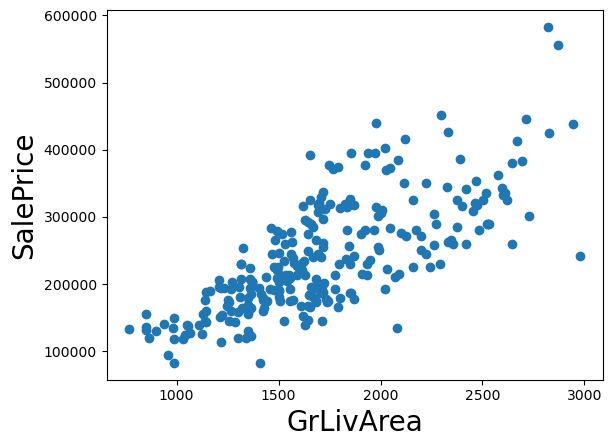

In [188]:
y = data['SalePrice']
x1 = data['GrLivArea']

plt.scatter(x1, y)
plt.xlabel('GrLivArea', fontsize = 20)
plt.ylabel('SalePrice', fontsize = 20)
plt.show()

# OLS Regression Reuslts

In [189]:
x = sm.add_constant(x1)
results = sm.OLS(y, x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     315.6
Date:                Mon, 30 Oct 2023   Prob (F-statistic):           7.99e-47
Time:                        00:11:45   Log-Likelihood:                -3252.4
No. Observations:                 263   AIC:                             6509.
Df Residuals:                     261   BIC:                             6516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6191.2115   1.36e+04      0.454      0.650   -2.07e+04    3.31e+04
GrLivArea    135.5524      7.631     17.764      0.000     120.527     150.578
==============================================================================
Omnibus:                       17.363   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.607
Skew:                           0.569   Prob(JB):                     5.53e-05
Kurtosis:                       3.704   Cond. No.                     6.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

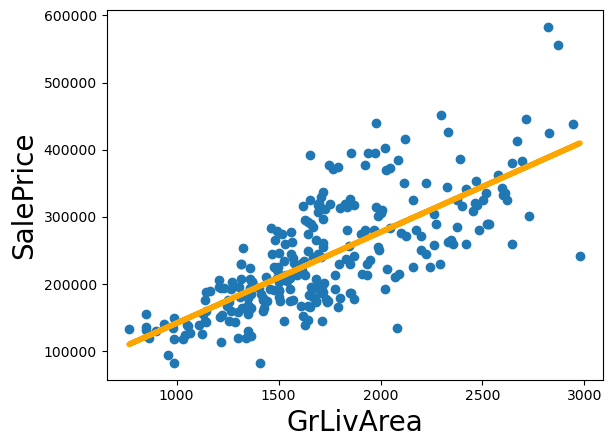

In [190]:
plt.scatter(x1, y)
yhat = 135.5524 * x1 + 6191.2115
fig = plt.plot(x1, yhat, lw=4,
               c='orange', label = 'regression line')
plt.xlabel('GrLivArea', fontsize = 20)
plt.ylabel('SalePrice', fontsize = 20)
plt.show()

# Regression(Quadratic technique)

In [191]:
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in qualitative:  
    encode(data, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['Neighborhood_E', 'RoofMatl_E']


In [198]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    data[feature] = np.log1p(data[feature].values)

def quadratic(feature):
    data[feature+'2'] = data[feature]**2
    
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')

qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']

data['HasBasement'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasGarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['Has2ndFloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasMasVnr'] = data['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
data['HasWoodDeck'] = data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasPorch'] = data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
data['HasPool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['IsNew'] = data['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']


features = quantitative + qual_encoded + boolean + qdr
lasso = linear_model.LassoLarsCV(max_iter=10000)
X = data[features].fillna(0.).values
Y = data['SalePrice'].values
lasso.fit(X, np.log(Y))

Ypred = np.exp(lasso.predict(X))
print("R-squard-error: ", error(Y, Ypred))

R-squard-error:  0.11475443899096462


# Create a model

In [219]:
model = Sequential()
model.add(Input(shape=(6,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(450, activation='relu'))
model.add(Dense(350, activation='relu'))
model.add(Dense(150, activation='linear'))
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               3584      
_________________________________________________________________
dense_9 (Dense)              (None, 450)               230850    
_________________________________________________________________
dense_10 (Dense)             (None, 350)               157850    
_________________________________________________________________
dense_11 (Dense)             (None, 150)               52650     
Total params: 444,934
Trainable params: 444,934
Non-trainable params: 0
_________________________________________________________________
None


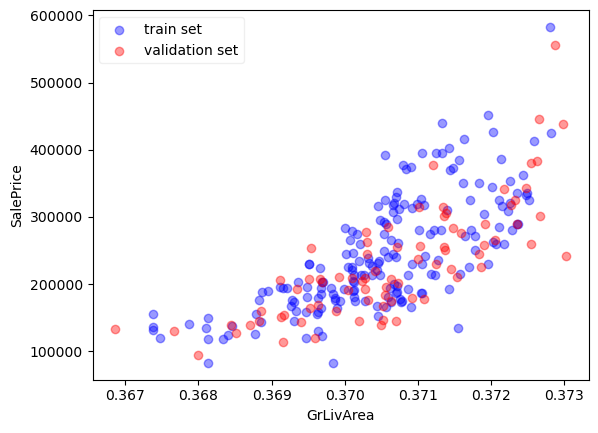

In [220]:
def split_dataset(data, train_frac=0.7):
    train = data.sample(frac=train_frac)
    val = data.drop(train.index)
    return train, val
    
# Split data into train and validation:
train, validation = split_dataset(data, train_frac=0.7)
plt.scatter(train['GrLivArea'], train['SalePrice'], c='blue', alpha=0.4)
plt.scatter(validation['GrLivArea'], validation['SalePrice'], c='red', alpha=0.4)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.legend(['train set', 'validation set'], framealpha=0.3)
plt.show()

In [221]:
# Train:
loss = 'mse'
metric = 'mae'

epochs = 150

x_train, y_train = train[['GrLivArea','YearRemodAdd','TotRmsAbvGrd','1stFlrSF','2ndFlrSF','GarageArea']], train['SalePrice']
x_val, y_val = validation[['GrLivArea','YearRemodAdd','TotRmsAbvGrd','1stFlrSF','2ndFlrSF','GarageArea']], validation['SalePrice']
model.compile(loss=loss, optimizer='adam', metrics=[metric])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1, validation_data=(x_val, y_val))


Epoch 1/150
3/3 [==============================] - 0s 60ms/step - loss: 66865516544.0000 - mae: 244445.5156 - val_loss: 60366213120.0000 - val_mae: 230915.8438
Epoch 2/150
3/3 [==============================] - 0s 13ms/step - loss: 66801049600.0000 - mae: 244312.2656 - val_loss: 60267159552.0000 - val_mae: 230701.4375
Epoch 3/150
3/3 [==============================] - 0s 13ms/step - loss: 66663718912.0000 - mae: 244035.7344 - val_loss: 60066476032.0000 - val_mae: 230266.3750
Epoch 4/150
3/3 [==============================] - 0s 12ms/step - loss: 66405064704.0000 - mae: 243497.1250 - val_loss: 59699261440.0000 - val_mae: 229468.1562
Epoch 5/150
3/3 [==============================] - 0s 14ms/step - loss: 65936486400.0000 - mae: 242534.7812 - val_loss: 59075469312.0000 - val_mae: 228105.5469
Epoch 6/150
3/3 [==============================] - 0s 14ms/step - loss: 65153867776.0000 - mae: 240928.3438 - val_loss: 58079490048.0000 - val_mae: 225912.4844
Epoch 7/150
3/3 [=======================

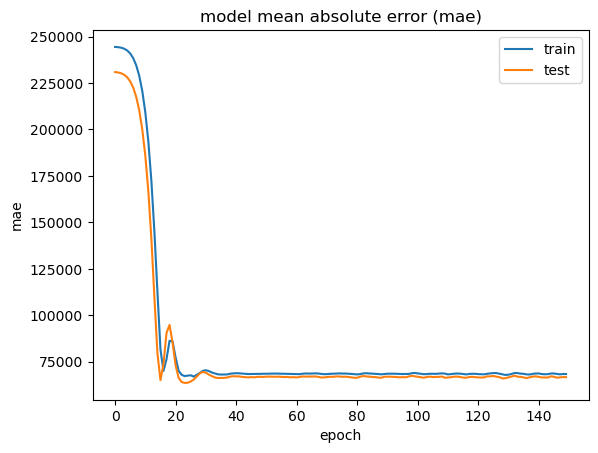

In [222]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mean absolute error (mae)')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()